<a href="https://colab.research.google.com/github/Lfirenzeg/msds620/blob/main/Project%201/620_LFMG_Centrality_Measures.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Data 620
# Centrality Measures

### By Luis Munoz Grass

This week's assignment is to identify an interesting set of network data that is available on the web (either through web scraping or web APIs) that could be used for analyzing and comparing centrality measures across nodes.  As an additional constraint, there should be at least one categorical variable available for each node (such as “Male” or “Female”; “Republican”, “Democrat,” or “Undecided”, etc.)

In addition to identifying your data source, you should create a high level plan that describes how you would load the data for analysis, and describe a hypothetical outcome that could be predicted from comparing degree centrality across categorical groups.

In [55]:
!pip install sodapy


In [82]:
from sodapy import Socrata
import pandas as pd
import networkx as nx
from networkx.algorithms import bipartite
import matplotlib.pyplot as plt
import seaborn as sns
import getpass
from scipy.stats import ttest_ind
from PIL import Image
import requests
from io import BytesIO

In [58]:
# enter your public App Token when prompted
app_token = getpass.getpass("Enter your Socrata App Token:")

# this will connect to NYC Open Data Socrata instance
client = Socrata("data.cityofnewyork.us", app_token=app_token)


Enter your Socrata App Token:··········


## Dataset: 2020-21 SMH Service Coverage

From the NYC Open Data website:
"A snapshot of mental health service coverage in DOE schools. Data extracts from each mental health service program are compiled monthly, each record represents a school that is covered by a mental health program. Data can be used to determine DOE schools with mental health coverage. The data does NOT show all mental health programs provided to a school."




In [59]:
# ID for 2020-21 SMH Service Coverage
dataset_id = "qxbt-vysj"

# to fetch all rows (more than default 1000 as indicated in the website instructions)
results = client.get(dataset_id, limit=2000)  # this will safely exceed total rows

df = pd.DataFrame.from_records(results)
df.head()


geographical_district_code building_code ats_system_code  \
0                          1          M015          01M015   
1                          1          M020          01M020   
2                          1          M034          01M034   
3                          1          M063          01M063   
4                          1          M064          01M064   

                    location_name     primary_address       city    zip  \
0       P.S. 015 Roberto Clemente   333 EAST 4 STREET  MANHATTAN  10009   
1            P.S. 020 Anna Silver    166 ESSEX STREET  MANHATTAN  10002   
2  P.S. 034 Franklin D. Roosevelt  730 EAST 12 STREET  MANHATTAN  10009   
3       The STAR Academy - P.S.63   121 EAST 3 STREET  MANHATTAN  10009   
4           P.S. 064 Robert Simon   600 EAST 6 STREET  MANHATTAN  10009   

                                       service  
0                          Community School MH  
1            School-based Mental Health Clinic  
2            School-based Mental Health Clinic  
3            School-based Mental Health Clinic  
4  School-based Health Center w/ Mental Health

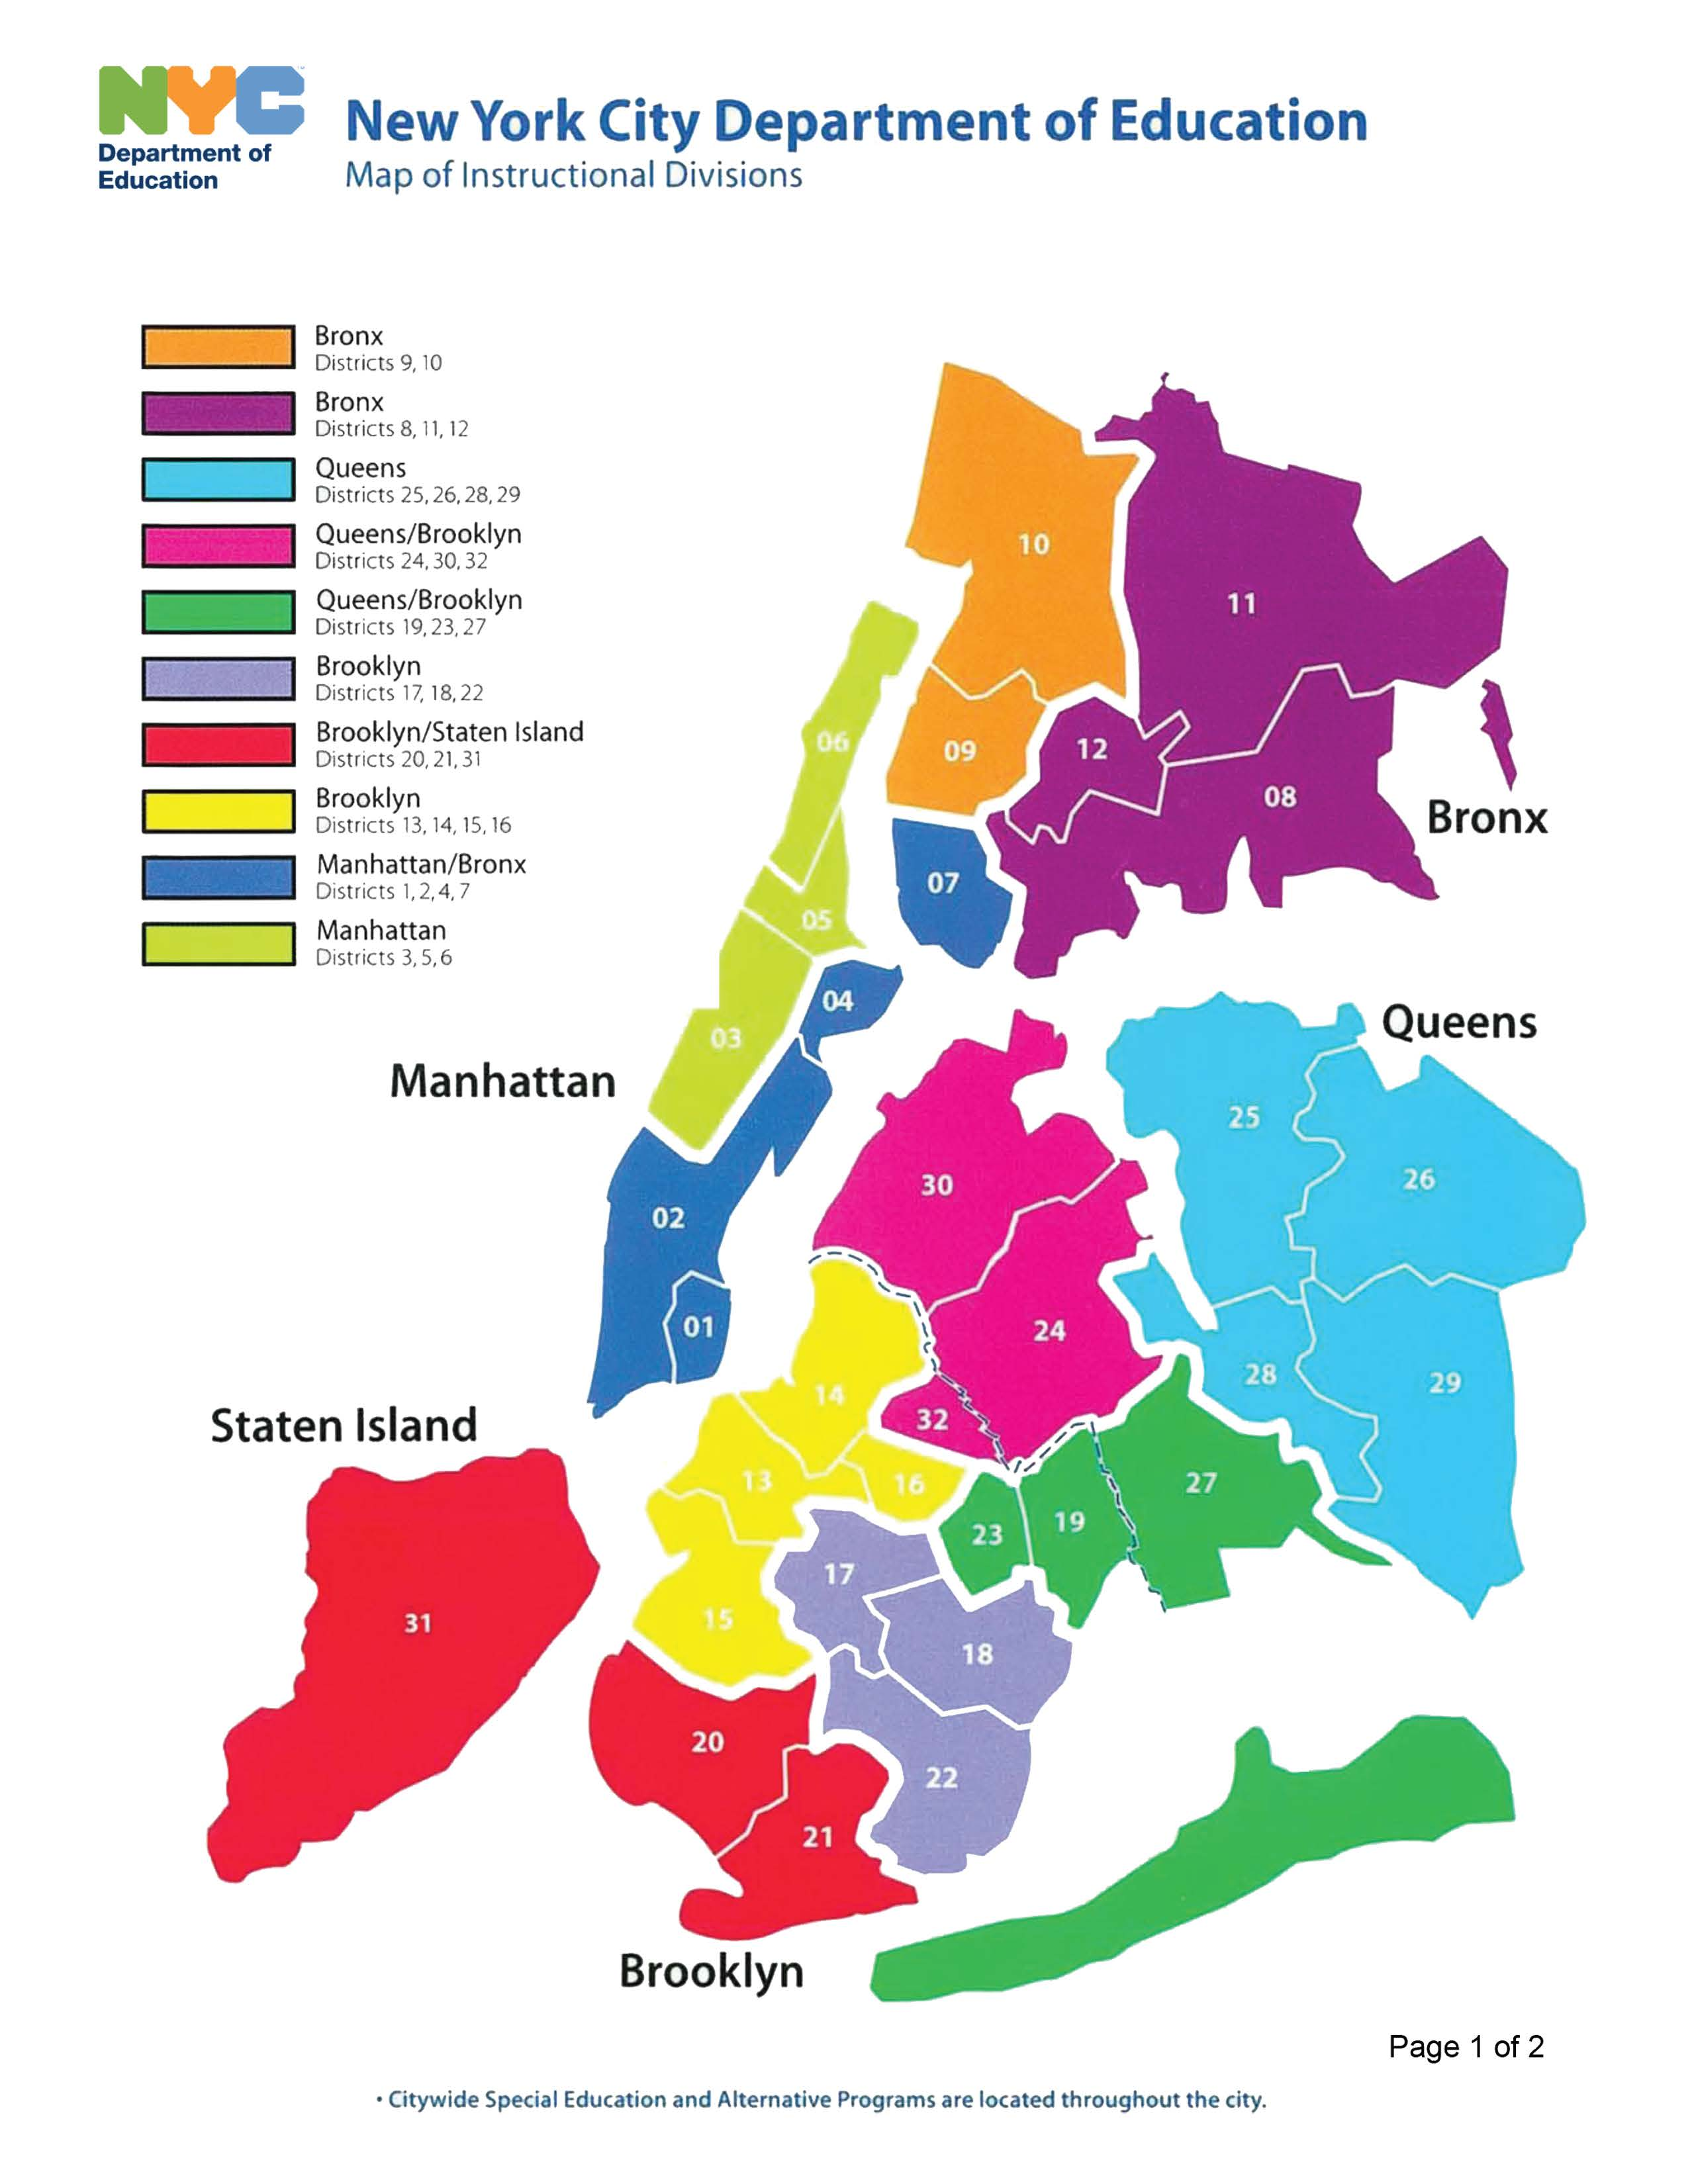

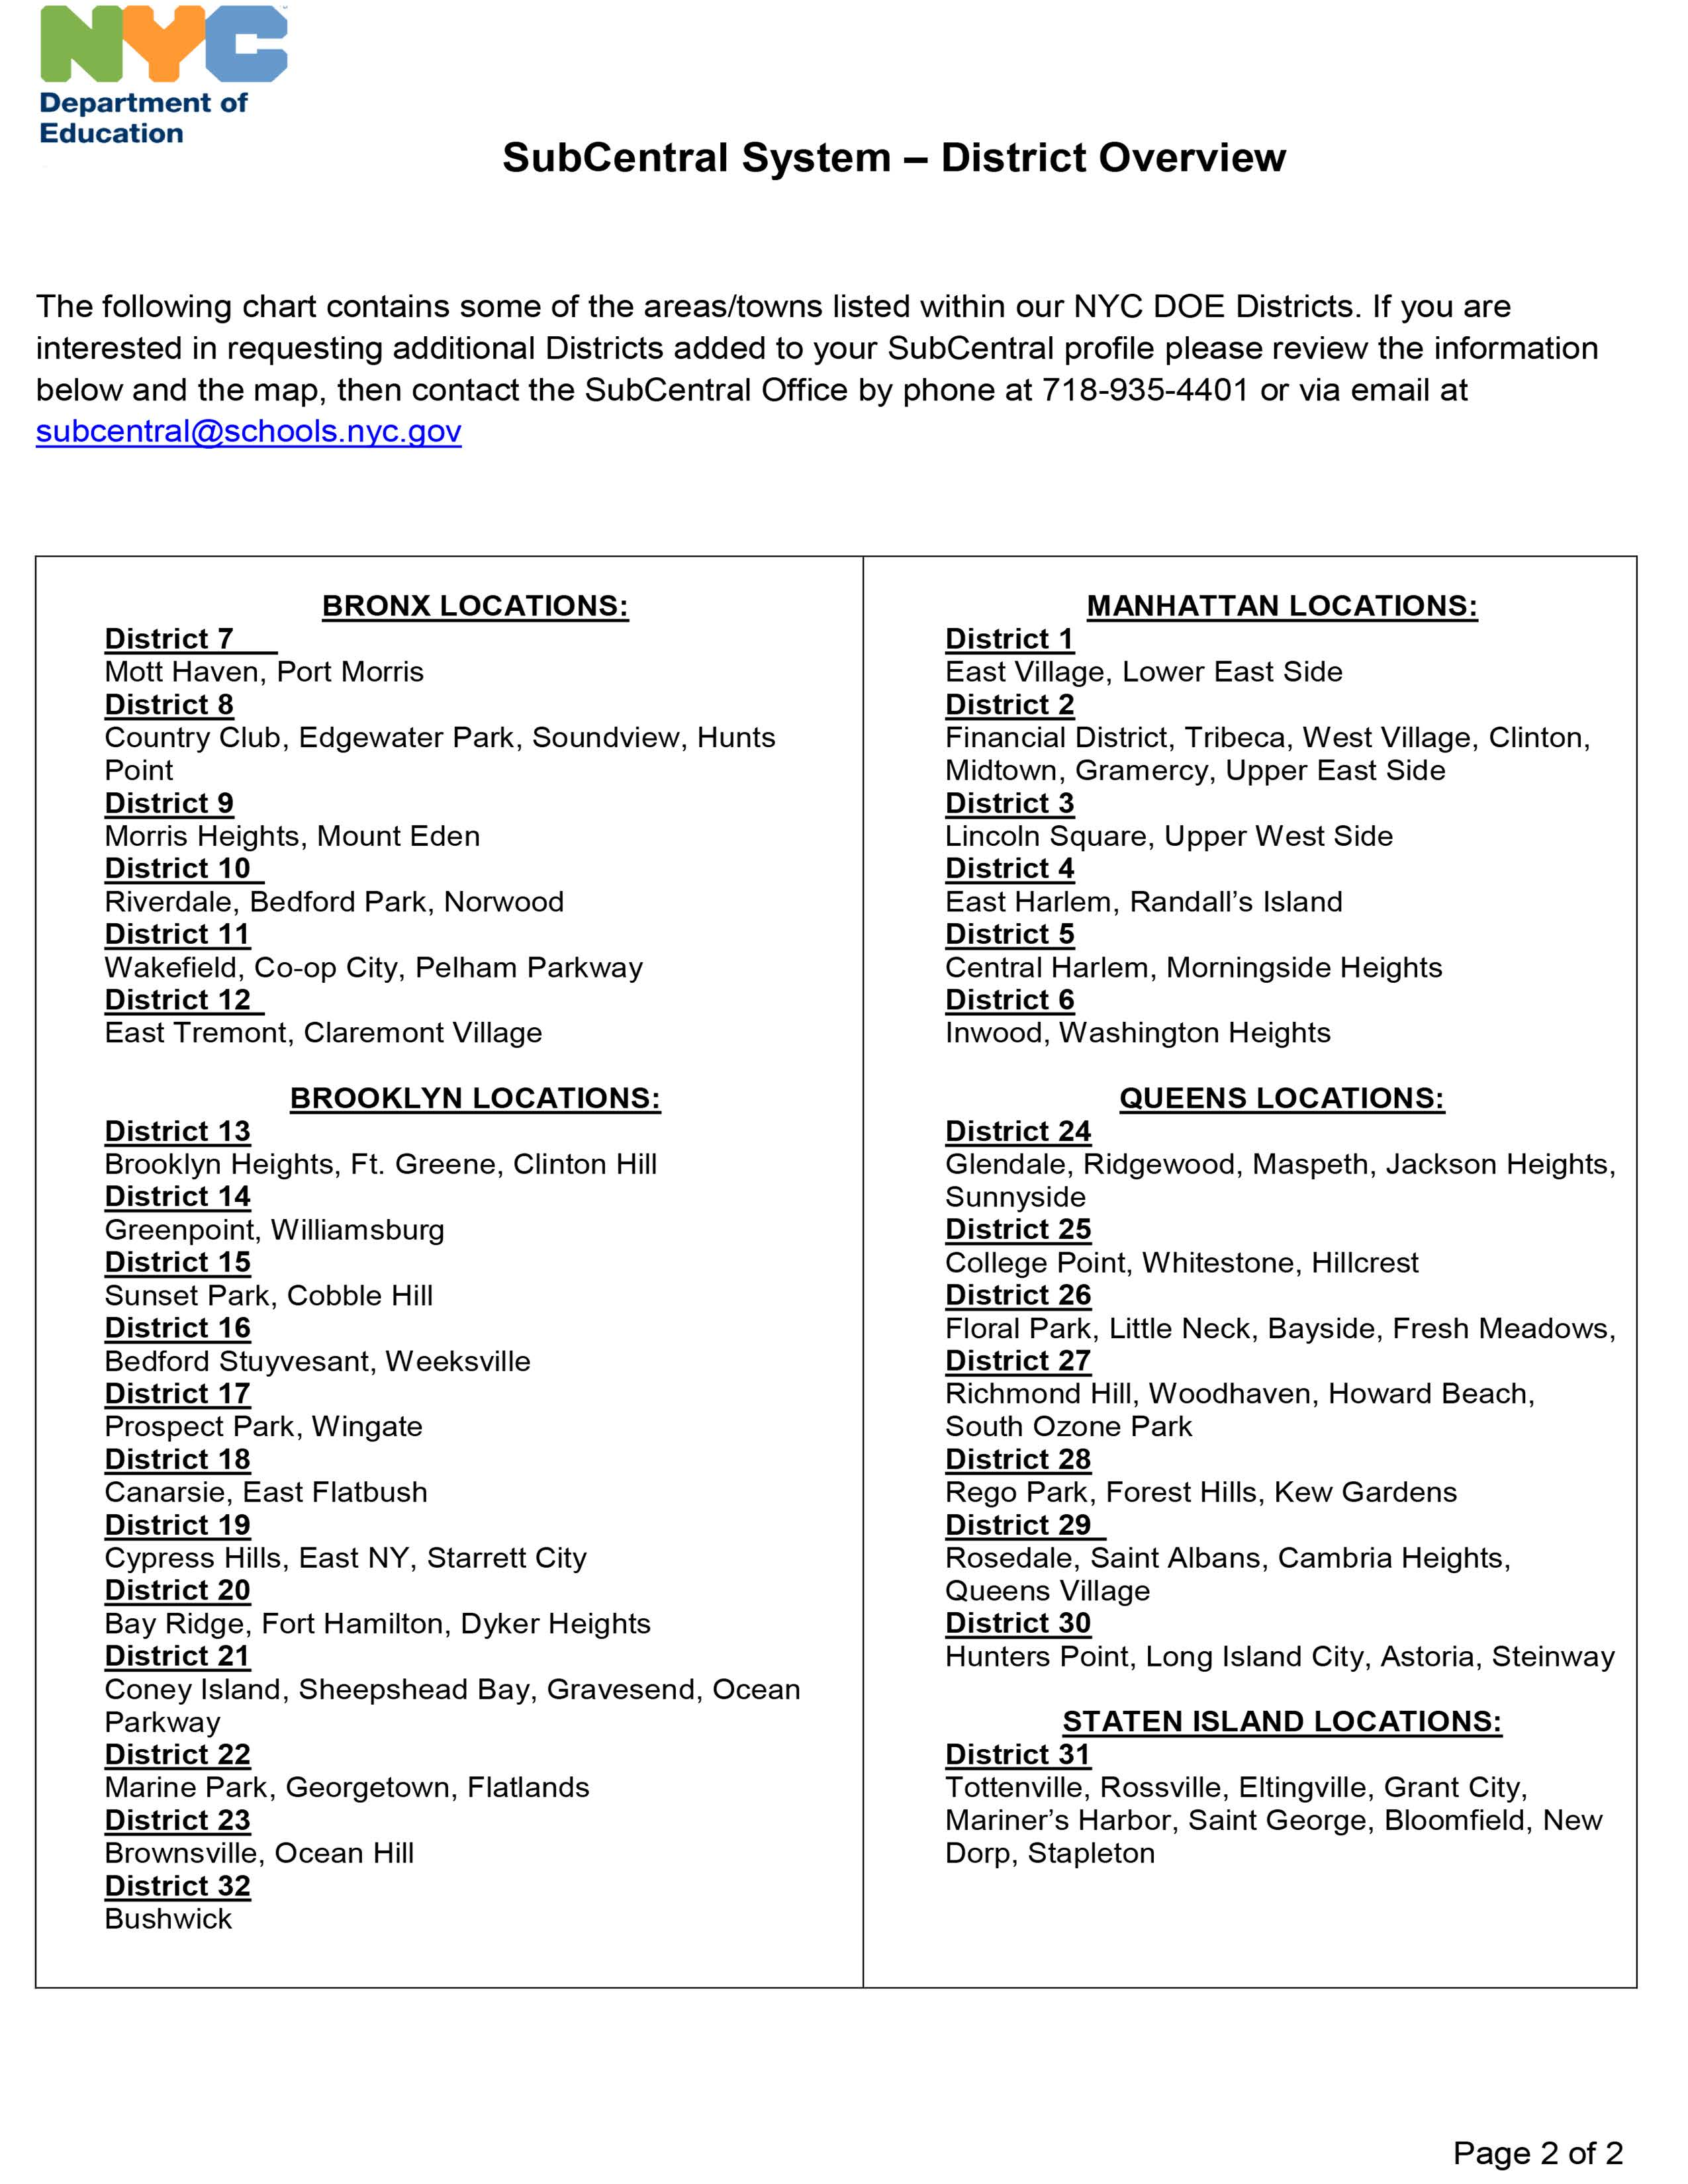

In [85]:
map_urls = [
    "https://raw.githubusercontent.com/Lfirenzeg/msds620/main/Project%201/nycdoe-district-mape429391a3b194b8ab106abb1d2ee44ca_Page_1.jpg",
    "https://raw.githubusercontent.com/Lfirenzeg/msds620/main/Project%201/nycdoe-district-mape429391a3b194b8ab106abb1d2ee44ca_Page_2.jpg"
]
for url in map_urls:
    response = requests.get(url)
    img = Image.open(BytesIO(response.content))
    display(img)

In [86]:
district_to_borough = {
    1: 'Manhattan', 2: 'Manhattan', 3: 'Manhattan', 4: 'Manhattan', 5: 'Manhattan', 6: 'Manhattan',
    7: 'Bronx', 8: 'Bronx', 9: 'Bronx', 10: 'Bronx', 11: 'Bronx', 12: 'Bronx',
    13: 'Brooklyn', 14: 'Brooklyn', 15: 'Brooklyn', 16: 'Brooklyn', 17: 'Brooklyn', 18: 'Brooklyn', 19: 'Brooklyn', 20: 'Brooklyn', 21: 'Brooklyn', 22: 'Brooklyn', 23: 'Brooklyn', 32: 'Brooklyn',
    24: 'Queens', 25: 'Queens', 26: 'Queens', 27: 'Queens', 28: 'Queens', 29: 'Queens', 30: 'Queens',
    31: 'Staten Island'
}


In [62]:
df['geographical_district_code'] = df['geographical_district_code'].astype(int)
df['borough'] = df['geographical_district_code'].map(district_to_borough)

In [64]:
# Extract node sets
schools = df['location_name'].unique().tolist()
services = df['service'].unique().tolist()

# Create bipartite graph
B = nx.Graph()

# Add nodes with bipartite attribute
B.add_nodes_from(schools, bipartite='school')
B.add_nodes_from(services, bipartite='service')

# Add edges from school to service
for _, row in df.iterrows():
    school = row['location_name']
    service = row['service']
    B.add_edge(school, service)


In [65]:
# Project bipartite graph onto school nodes
school_projection = bipartite.projected_graph(B, schools)

# Preview nodes and edges
print(f"Number of schools: {len(school_projection.nodes)}")
print(f"Number of shared-service links: {len(school_projection.edges)}")


Number of schools: 1025
Number of shared-service links: 120957


In [71]:
# Calculate degree centrality
degree_centrality = nx.degree_centrality(school_projection)
eigenvector_centrality = nx.eigenvector_centrality(school_projection, max_iter=1000)

centrality_df = pd.DataFrame({
    'school': list(degree_centrality.keys()),
    'degree_centrality': list(degree_centrality.values()),
    'eigenvector_centrality': [eigenvector_centrality[s] for s in degree_centrality.keys()]
})


In [72]:
school_to_district = df.drop_duplicates('location_name').set_index('location_name')['geographical_district_code'].to_dict()
school_to_borough = df.drop_duplicates('location_name').set_index('location_name')['borough'].to_dict()
centrality_df['district'] = centrality_df['school'].map(school_to_district)
centrality_df['borough'] = centrality_df['school'].map(school_to_borough)

In [73]:
# Create mapping from school to borough
school_to_borough = df.drop_duplicates('location_name').set_index('location_name')['borough'].to_dict()

# Add borough info to centrality_df
centrality_df['borough'] = centrality_df['school'].map(school_to_borough)


## Degree Centrality

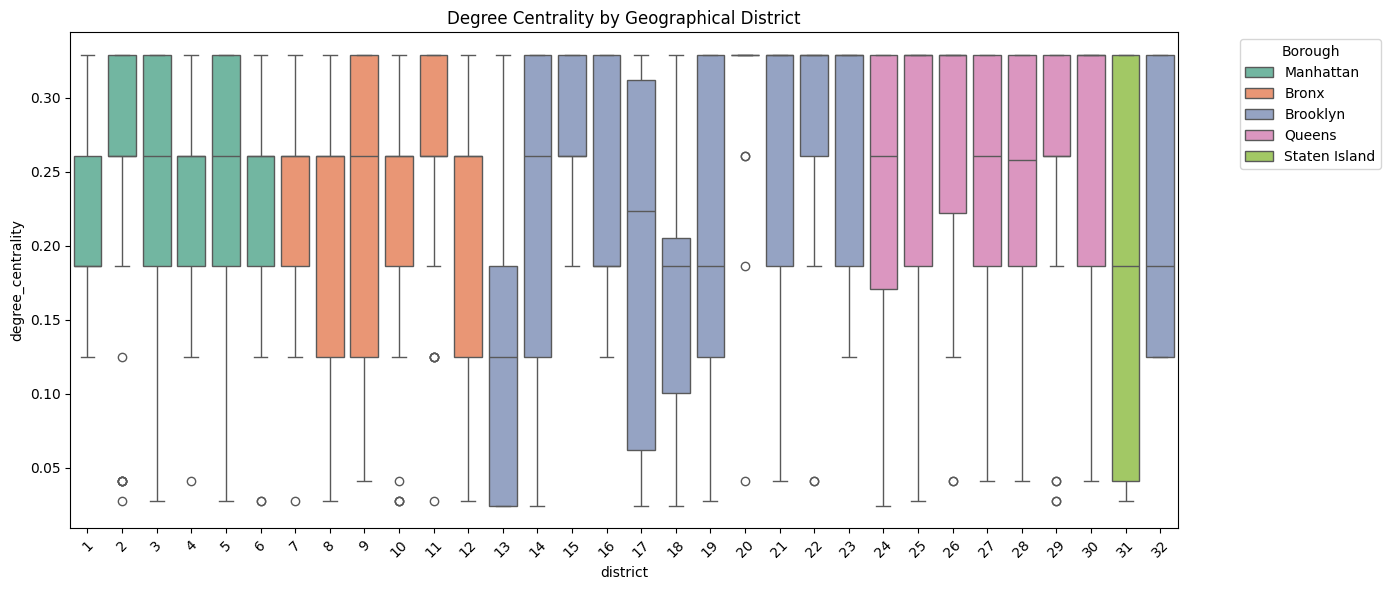

In [75]:
plt.figure(figsize=(14,6))
sns.boxplot(
    x='district',
    y='degree_centrality',
    hue='borough',
    data=centrality_df,
    dodge=False,
    palette='Set2'
)
plt.title("Degree Centrality by Geographical District")
plt.xticks(rotation=45)
plt.legend(title='Borough', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()



Overall, Brooklyn and Queens show the widest variability, with several districts displaying high median centrality and long ranges, suggesting that schools in these boroughs are highly engaged in service-sharing networks although unevenly across districts.

Districts 13, 17, 19, and 31 have lower median centrality

Districts like 2, 3, 14, 15 seem to have higher overall centrality

Some districts show more variation with wider boxes, which could indicate inequality in service overlap

Manhattan and the Bronx exhibit more uniform but moderate centrality, indicating that schools tend to share services at a similar rate.

On the other hand, Staten Island schools show lower and more consistent degree centrality, with limited inter-school connections, likely due to geographic separation or smaller network size.

We can get from this that schools in some districts are more "networked" as they share mental health services with more peers, possibly reflecting service availability or clusters of schools.



In [80]:
# Manhattan vs other Boroughs
manhattan_dc = centrality_df[centrality_df['borough'] == 'Manhattan']['degree_centrality']
others_dc = centrality_df[centrality_df['borough'] != 'Manhattan']['degree_centrality']
t_stat_dc, p_val_dc = ttest_ind(manhattan_dc, others_dc)
print(f"T-test (Degree Centrality): t = {t_stat_dc:.3f}, p = {p_val_dc:.3f}")

T-test (Degree Centrality): t = 1.355, p = 0.176


From the previous result we can say there is no statistically significant difference in degree centrality between schools in Manhattan and those in the rest of NYC.

In this case degree centrality reflects the number of direct connections a school has to other schools (via shared services).

The similarity suggests that Manhattan schools are not significantly more or less connected than schools in other boroughs through shared mental health services.

## Eigenvector Centrality



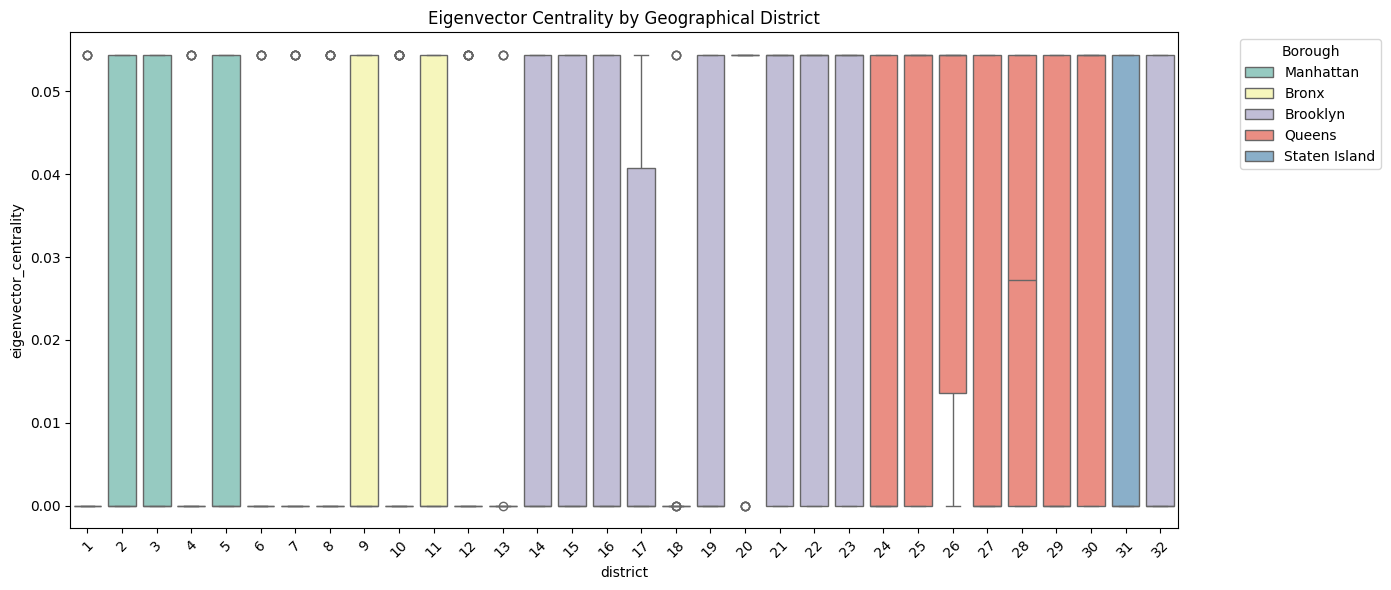

In [76]:
plt.figure(figsize=(14,6))
sns.boxplot(
    x='district',
    y='eigenvector_centrality',
    hue='borough',
    data=centrality_df,
    dodge=False,
    palette='Set3'
)
plt.title("Eigenvector Centrality by Geographical District")
plt.xticks(rotation=45)
plt.legend(title='Borough', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

The eigenvector centrality plot shows Brooklyn and Queens again leading, with multiple districts containing schools that are central to the broader  structure to share services. This suggests that schools in these boroughs not only share services widely but are embedded in clusters with other influential institutions.

Meanwhile, Manhattan and the Bronx have lower eigenvector scores across most districts, indicating that their schools are less embedded in key hubs of the network.

Staten Island, with its single district, exhibits the lowest eigenvector centrality, reinforcing its status as an outlier with limited integration into the citywide service network.

In [81]:
manhattan_ev = centrality_df[centrality_df['borough'] == 'Manhattan']['eigenvector_centrality']
others_ev = centrality_df[centrality_df['borough'] != 'Manhattan']['eigenvector_centrality']
t_stat_ev, p_val_ev = ttest_ind(manhattan_ev, others_ev)
print(f"T-test (Eigenvector Centrality): t = {t_stat_ev:.3f}, p = {p_val_ev:.3f}")


T-test (Eigenvector Centrality): t = -2.492, p = 0.013


Now we can see that there is a statistically significant difference in eigenvector centrality between Manhattan and the other boroughs.

For our case, eigenvector centrality considers not only how many connections a school has, but also how central their neighbors are.

The negative t-value suggests that Manhattan schools tend to be more peripheral in the overall network, meaning they are less connected to other highly central schools.

This could imply less integration or isolation in the service-sharing structure, potentially impacting how influence or resources flow.

Overall, degree centrality varied more noticeably across geographical districts but eigenvector centrality showed less differentiation. T-tests between districts 1 and 2 revealed no statistically significant differences for either measure (p = 0.091 for degree, p = 0.135 for eigenvector). Although some schools may be slightly more interconnected, influence within the network is fairly balanced across districts.

From all this we can gather that Brooklyn and Queens tend to contain central hubs of schools that are both well connected and connected to other well-connected schools. Manhattan and Bronx, despite having many schools, appear more marginal in the network, with limited connections to influential schools. Staten Island is the most isolated in both cases.